In [1]:
# import system libraries
import logging
import sys, copy
# import scientific libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import h5py
import pandas as pd
# import data analysis libraries
from ldc.waveform.lisabeta import FastBHB
import lisabeta.lisa.lisa as lisa
from lisabeta.lisa.lisa import EvaluateTDIFreqseries
import lisabeta.tools.pyspline as pyspline
import lisabeta.lisa.lisatools as lisatools
import lisabeta.tools.pytools as pytools
from ldc.common import tools
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import lisaconstants
# import sampler libraries
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer

mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
pMBHB_ldc = {
            'EclipticLatitude': -0.30300442294174235,
            'EclipticLongitude': 1.2925183861048521,
            'PolarAngleOfSpin1': 1.2031361791056812,
            'PolarAngleOfSpin2': 2.097303543065685,
            'Spin1': 0.747377,
            'Spin2': 0.8388,
            'Mass1': 1323277.47932,
            'Mass2': 612485.5060299999,
            'CoalescenceTime': 11526944.921879262,
            'PhaseAtCoalescence': 1.2201968860015653,
            'InitialPolarAngleL': 2.6919824500032945,
            'InitialAzimuthalAngleL': 1.808398497592109,
            'Redshift': 1.73941,
            'Distance': 13449.011,
            'ObservationDuration': 31558149.763545603,
            'Cadence': 3.0}

In [3]:
dt = 5
tmax = 3.155815e+05 # in [sec]

In [4]:
FBH = FastBHB("MBHB", T=tmax, delta_t=dt, approx="IMRPhenomD")

pMBHB = FBH.rename_as_lisabeta(pMBHB_ldc)

print(pMBHB.keys())

dict_keys(['beta', 'lambda', 'chi1', 'chi2', 'm1', 'm2', 'Deltat', 'phi', 'dist', 'psi', 'inc'])


In [5]:
waveform_params_smbh = {
    "minf": 1e-5,
    "maxf": 1,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "tmax": 1.0,
    "TDI": "TDI2AET",
    "approximant": "IMRPhenomD",
    "TDIrescaled": False,
}

In [6]:
tdisignal = lisa.GenerateLISATDISignal_SMBH(pMBHB, **waveform_params_smbh)

In [7]:
tdi = tdisignal['tdi']


In [8]:
mbh_lb = tdi[(2,2)]

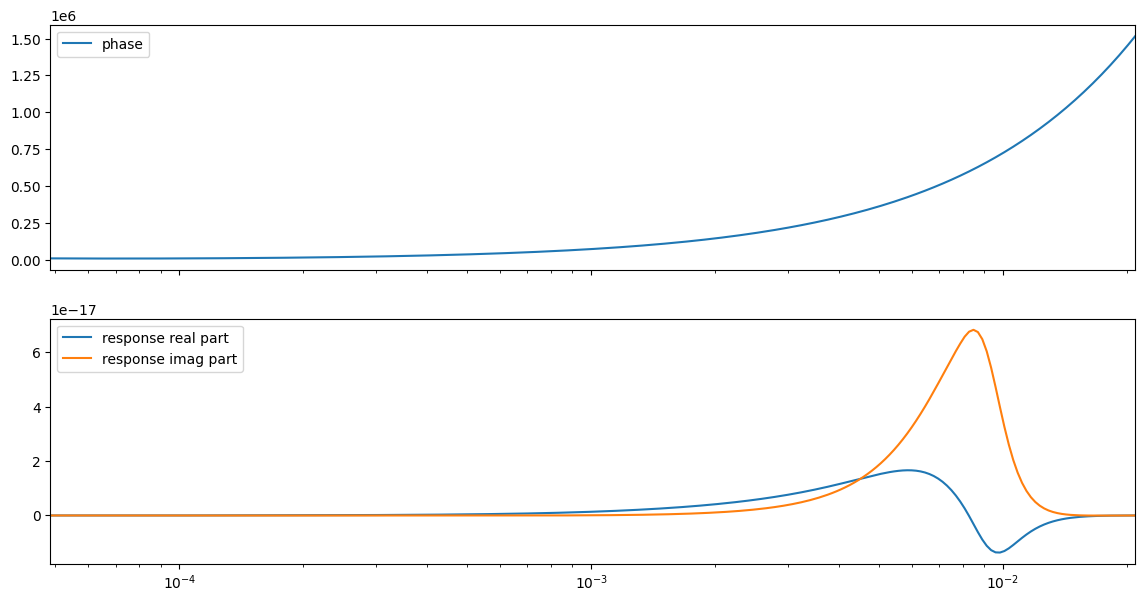

In [9]:
fig, ax = plt.subplots(figsize=(14,7), nrows=2, ncols=1, sharex=True)
ax[0].semilogx(mbh_lb['freq'], mbh_lb['phase'], label="phase")
ax[0].legend(loc = 'upper left')
ax[1].semilogx(mbh_lb['freq'], mbh_lb['amp_real_chan1'], label='response real part')
ax[1].semilogx(mbh_lb['freq'], mbh_lb['amp_imag_chan1'], label='response imag part')
ax[1].legend(loc = 'upper left')
plt.axis([mbh_lb['freq'][0], mbh_lb['freq'][-1], None, None])
plt.show()

In [10]:
 # frequency band of the signal
fmin = mbh_lb['freq'][0]
fmax = mbh_lb['freq'][-1]
ndata = int(tmax/dt)
df = 1/tmax

# Get the full frequencies
if (ndata % 2)==0:              # Get the number of requencies
    nfft = int((ndata/2)+1)
else:
    nfft = int((ndata+1)/2)

F = df*nfft                 # make the positive frequency vector
fvec = np.arange(0, F, df)

# Get the frequencies of interest
f_inds = np.where(np.logical_and(fvec >= fmin, fvec < fmax))
fvec = fvec[f_inds]
print(fvec)


[5.07000569e-05 5.38688104e-05 5.70375640e-05 ... 2.09676423e-02
 2.09708110e-02 2.09739798e-02]


In [11]:
# constructing spline
splPh = spline(mbh_lb['freq'], mbh_lb['phase'], ext='raise') # Note the raise!
splAr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan1'])
splAi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan1'])

# constructing signal at each Fouriner freq.
Afull = np.conjugate((splAr(fvec) + 1.j*splAi(fvec))*np.exp(1j*splPh(fvec)))

In [12]:
Afull_another_way = np.conj(EvaluateTDIFreqseries(tdisignal['tdi'], fvec)[(2, 2)]['chan1'])

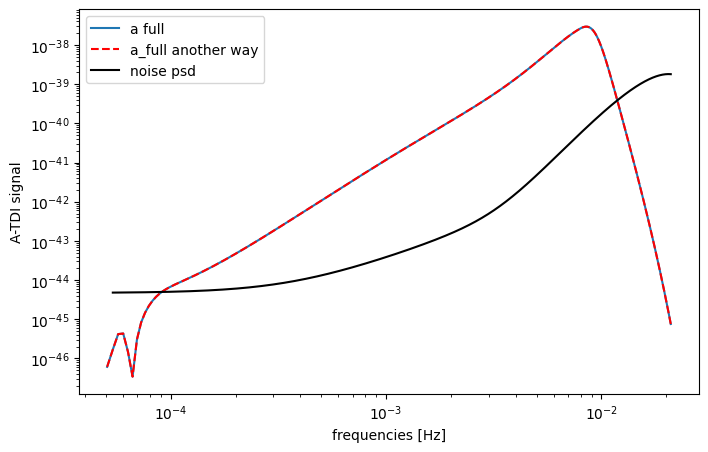

In [13]:
# adding the noise
Nmodel = AnalyticNoise(fvec[1:], model="SciRDv1") # or whatever version you prefer. In the previous notebook we used "sangria"
Npsd = Nmodel.psd(option='A', tdi2=True)

plt.figure(figsize=(8,5))

plt.loglog(fvec, 2*df*np.abs(Afull)**2, label = 'a full')
plt.loglog(fvec, 2*df*np.abs(Afull_another_way)**2, 'r--', label = 'a_full another way')

plt.loglog(fvec[1:], Npsd, 'k', label = 'noise psd')

plt.ylabel("A-TDI signal")
plt.xlabel("frequencies [Hz]")
plt.legend()
plt.show()

In [14]:
print(np.max(fvec))

0.020973979780183567


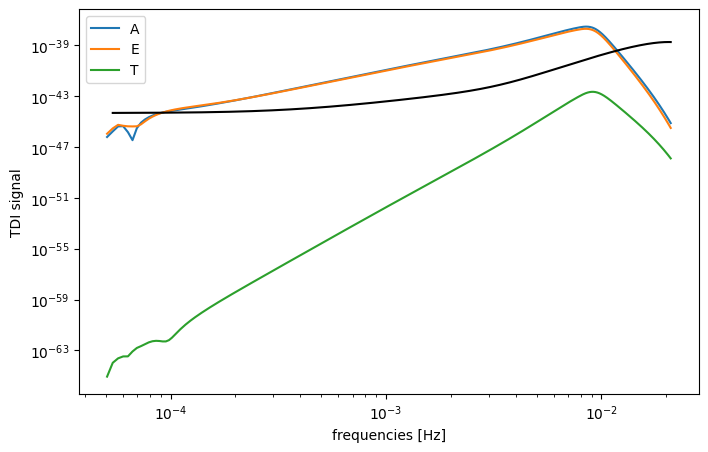

In [15]:
# constructing spline of E
splEr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan2'])
splEi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan2'])

# constructing signal at each Fouriner freq. for E channel
Efull = np.conjugate((splEr(fvec) + 1.j*splEi(fvec))*np.exp(1j*splPh(fvec)))

# constructing spline of E
splTr = spline(mbh_lb['freq'], mbh_lb['amp_real_chan3'])
splTi = spline(mbh_lb['freq'], mbh_lb['amp_imag_chan3'])

# constructing signal at each Fouriner freq. for E channel
Tfull = np.conjugate((splTr(fvec) + 1.j*splTi(fvec))*np.exp(1j*splPh(fvec)))

plt.figure(figsize=(8,5))
plt.loglog(fvec, 2*df*np.abs(Afull)**2, label='A')
plt.loglog(fvec, 2*df*np.abs(Efull)**2, label='E')
plt.loglog(fvec, 2*df*np.abs(Tfull)**2, label='T')

plt.loglog(fvec[1:], Npsd, 'k')

plt.ylabel("TDI signal")
plt.xlabel("frequencies [Hz]")
plt.legend()
plt.show()

In [16]:
Nmodel = AnalyticNoise(fvec, model="SciRDv1") # or whatever version you prefer. In the previous notebook we used "sangria"
Npsd = Nmodel.psd(option='A', tdi2=True)

In [17]:

ntemps = 5
nwalkers = 20
nsamples = 2000
ndims = {"mbh": 3}


In [18]:

m1 = pMBHB['m1']
m2 = pMBHB['m2']

q = m1/m2
Mc = (m1+m2)*(q/(1+q)**2)**0.6

pMBHB["Mchirp"] = Mc
pMBHB["q"] = q

pMBHB_fit = copy.deepcopy(pMBHB)

# Remove those keys, otherwise the code will
# fit for m1 and m2 instead of Mchirp and q.
del pMBHB_fit["m1"]
del pMBHB_fit["m2"]

DA = Afull.copy()
DE = Efull.copy()

def likelihood_2chnls(pvector):

    Mc, q, chi1, chi2,  = pvector[:]
    pMBHB_fit["Mchirp"] = Mc
    pMBHB_fit["q"] = q
    pMBHB_fit["dist"] = dist

    h_tdi = lisa.GenerateLISATDISignal_SMBH(pMBHB_fit, **waveform_params_smbh)['tdi'][(2,2)]

    # Phase
    splPh = spline(h_tdi['freq'], h_tdi['phase'])
    Ph = splPh(fvec)

    # A
    splAr = spline(h_tdi['freq'], h_tdi['amp_real_chan1'])
    splAi = spline(h_tdi['freq'], h_tdi['amp_imag_chan1'])
    hA = np.conjugate((splAr(fvec) + 1.j*splAi(fvec))*np.exp(1j*Ph))

    # E
    splEr = spline(h_tdi['freq'], h_tdi['amp_real_chan2'])
    splEi = spline(h_tdi['freq'], h_tdi['amp_imag_chan2'])
    hE = np.conjugate((splEr(fvec) + 1.j*splEi(fvec))*np.exp(1j*Ph))

    SN_m = 4.0 * df * np.sum( np.real(DA*np.conjugate(hA)) / Npsd ) \
          + 4.0 * df * np.sum( np.real(DE*np.conjugate(hE)) / Npsd )

    XX = 4.0 * df * np.sum( np.abs(hA)**2 / Npsd ) \
        + 4.0 * df * np.sum( np.abs(hE)**2 / Npsd )

    loglik = SN_m - 0.5*XX

    return loglik

In [19]:
def compute_likelihood(D, h, Sn, df):
    SN_m = 4.0*df* np.sum( np.real(D*np.conjugate(h))/Sn )
    XX = 4.0*df*np.sum( np.abs(h)**2/Sn )
    loglik = SN_m - 0.5*XX
    return (SN_m, XX, loglik)

SN2, XX, loglik =  compute_likelihood(Afull, Afull, Npsd, df)

print(SN2, XX, loglik)

#print (f'for A-TDI: the optimal SNR  {np.sqrt(XX)} and likelihood is {loglik}')

3556045.1410530587 3556045.1410530587 1778022.5705265293


In [20]:
#do it for everything instead
day_sec = 86400

priors = {"mbh": ProbDistContainer({
    0: uniform_dist(-np.pi/2, np.pi/2), #lambda
    1: uniform_dist(-np.pi, np.pi), #beta
    2: uniform_dist(-1, 1), #chi1
    3: uniform_dist(-1, 1), #chi2
    4: uniform_dist(100*day_sec, 175*day_sec), #deltat
    5: uniform_dist(-np.pi, np.pi), #phi
    6: uniform_dist(2000.0, 2000000.0), #dist
    7: uniform_dist(0., np.pi), #psi
    8: uniform_dist(0., np.pi), #inc
    9: uniform_dist(1e4, 1e7), #mchirp
    10: uniform_dist(1, 30), #q
})}

ndims = {"mbh": 11}

In [21]:
m1 = pMBHB['m1']
m2 = pMBHB['m2']
q = m1/m2
Mc = (m1+m2)*(q/(1+q)**2)**0.6

src0 = pMBHB.copy()
src0.pop("m1"); src0.pop("m2")
src0["Mchirp"] = Mc
src0["q"] = q
src0['psi'] += np.pi
src0['phi'] -= np.pi

print(src0)

{'beta': -0.30300442294174235, 'lambda': 1.2925183861048521, 'chi1': np.float64(0.26863190922667673), 'chi2': np.float64(-0.4215109787709388), 'Deltat': 11526944.921879262, 'phi': -1.9213957675882278, 'dist': 13449.011, 'psi': np.float64(1.2912226019238924), 'inc': np.float64(2.2517895222056112), 'Mchirp': 772462.8571528315, 'q': 2.160504152820206}


In [22]:
m1 = pMBHB['m1']
m2 = pMBHB['m2']

q = m1/m2
Mc = (m1+m2)*(q/(1+q)**2)**0.6

pMBHB["Mchirp"] = Mc
pMBHB["q"] = q

pMBHB_fit = copy.deepcopy(pMBHB)

# Remove those keys, otherwise the code will
# fit for m1 and m2 instead of Mchirp and q.
del pMBHB_fit["m1"]
del pMBHB_fit["m2"]

DA = Afull.copy()
DE = Efull.copy()

keys = src0.keys()

def likelihood_allchan(pvector):

    #For holding things constant
    #Mc, q, chi1, chi2 = pvector[:]
    #pMBHB_fit["Mchirp"] = Mc
    #pMBHB_fit["q"] = q
    #pMBHB_fit["chi1"] = chi1
    #pMBHB_fit["chi2"] = chi2

    src={k: v for k,v in zip(keys,pvector)}

    h_tdi = lisa.GenerateLISATDISignal_SMBH(src, 
                                            gridfreq=fvec,
                                            **waveform_params_smbh)['tdi'][(2,2)]

    # Phase
    splPh = spline(h_tdi['freq'], h_tdi['phase'])
    Ph = splPh(fvec)

    # A
    splAr = spline(h_tdi['freq'], h_tdi['amp_real_chan1'])
    splAi = spline(h_tdi['freq'], h_tdi['amp_imag_chan1'])
    hA = np.conjugate((splAr(fvec) + 1.j*splAi(fvec))*np.exp(1j*Ph))

    # E
    splEr = spline(h_tdi['freq'], h_tdi['amp_real_chan2'])
    splEi = spline(h_tdi['freq'], h_tdi['amp_imag_chan2'])
    hE = np.conjugate((splEr(fvec) + 1.j*splEi(fvec))*np.exp(1j*Ph))

    SN_m = 4.0 * df * np.sum( np.real(DA*np.conjugate(hA)) / Npsd ) \
          + 4.0 * df * np.sum( np.real(DE*np.conjugate(hE)) / Npsd )
    

    XX = 4.0 * df * np.sum( np.abs(hA)**2 / Npsd ) \
        + 4.0 * df * np.sum( np.abs(hE)**2 / Npsd )
    

    loglik = SN_m - 0.5*XX

    return loglik

In [23]:
nwalkers = 2*ndims["mbh"]

sampler_all_params = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood_allchan,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)

In [24]:
'''
truth_values = np.array(list([src0['chi1'], src0['chi2'], src0['Mchirp'], src0['q']]))
                        
print(truth_values)

theta0 = np.array([[np.hstack(
          (np.random.randn(ndims["mbh"]) * 1e-8) + truth_values)
          for i in range(nwalkers)]
          for _ in range(ntemps)])
'''

'\ntruth_values = np.array(list([src0[\'chi1\'], src0[\'chi2\'], src0[\'Mchirp\'], src0[\'q\']]))\n\nprint(truth_values)\n\ntheta0 = np.array([[np.hstack(\n          (np.random.randn(ndims["mbh"]) * 1e-8) + truth_values)\n          for i in range(nwalkers)]\n          for _ in range(ntemps)])\n'

In [25]:

injection_params_sub = np.array([src0["Mchirp"], src0["q"], src0["dist"]])

theta0 = np.array([[np.hstack(
          (np.random.randn(3) * 1e-8) + np.array([src0["Mchirp"], src0["q"], src0["dist"]]))
          for i in range(nwalkers)]
          for _ in range(ntemps)])

start_state = State({"mbh": theta0})


In [26]:
sampler_all_params.run_mcmc(start_state, nsamples, progress=True)

ValueError: incompatible input dimensions

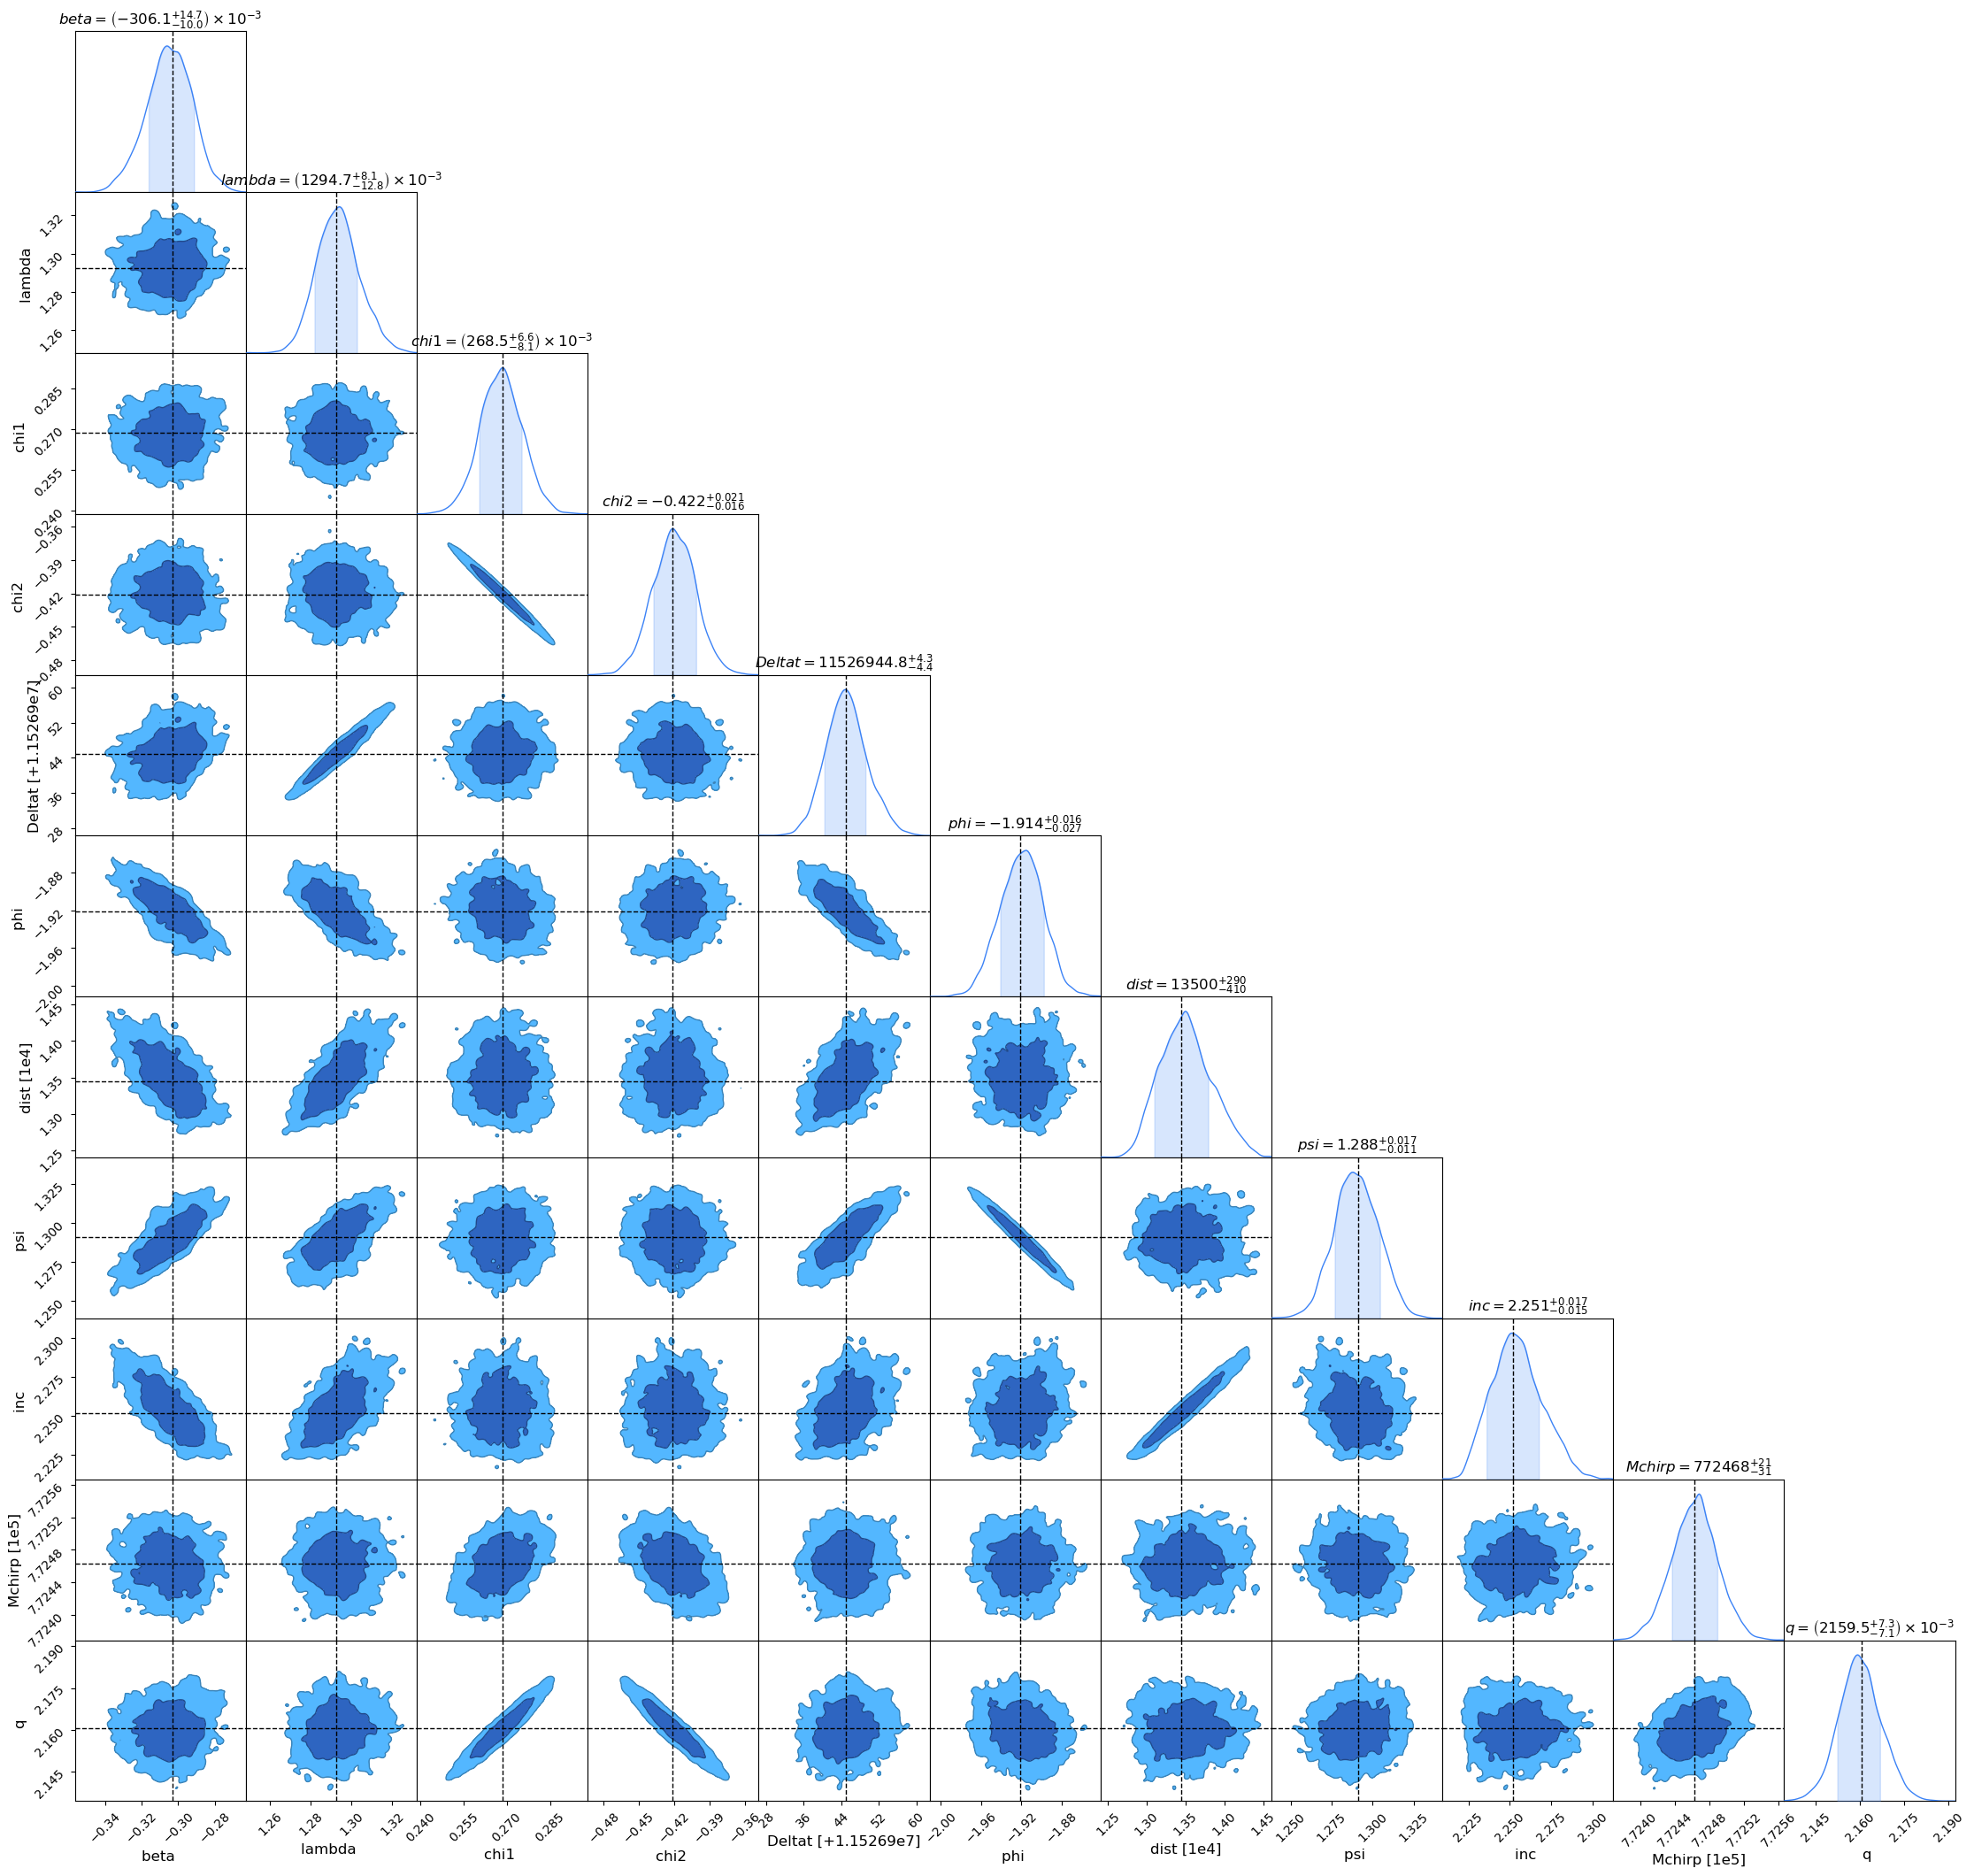

In [ ]:
burn = 15000

samples_2ch = sampler_all_params.get_chain()["mbh"][:, 0].reshape(-1, 11)
dfs_2chnls = pd.DataFrame(samples_2ch[burn:, :], columns=src0.keys())

c = ChainConsumer()

#
keys = src0.keys()
labels = list(keys)

inj=np.array(list(src0.values()))

truths = inj.flatten()
labels_final = labels
c.add_truth(Truth(location={k:v for (k,v) in zip(labels_final,truths)}))
#


c.add_chain(Chain(samples=dfs_2chnls, name="Two channels"))

fig = c.plotter.plot()
plt.show()

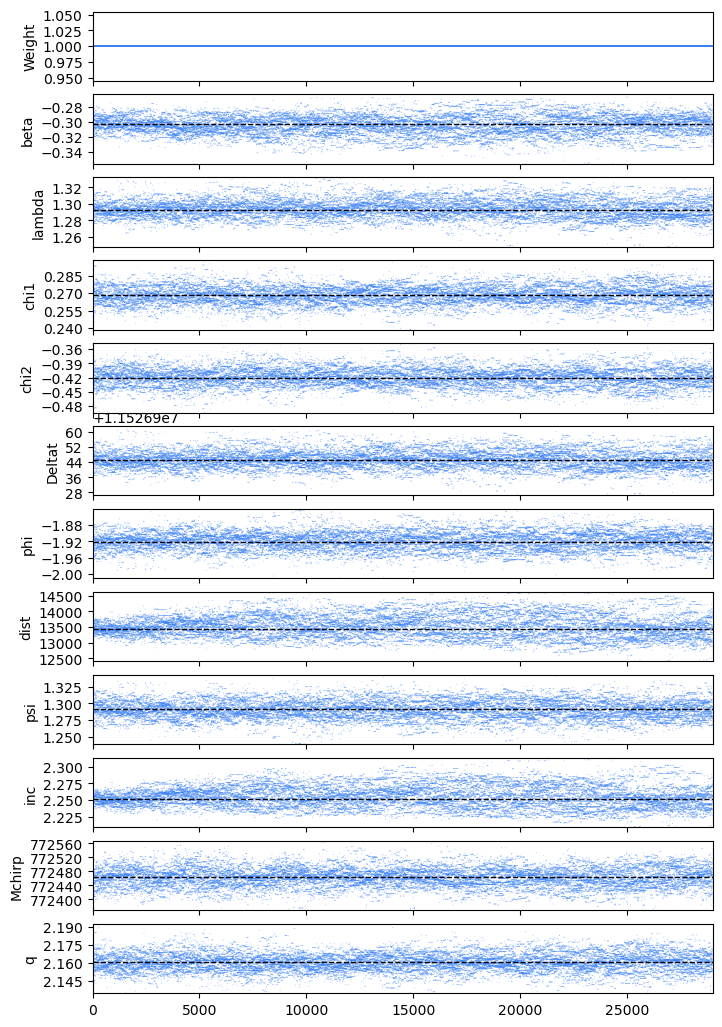

In [ ]:
fig = c.plotter.plot_walks()
plt.show()

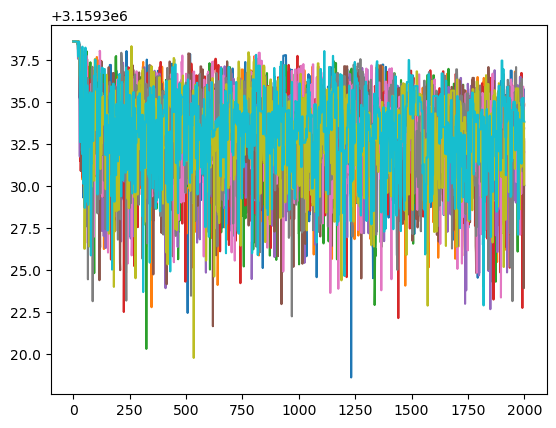

In [ ]:
log_lik = sampler_all_params.backend.get_log_like()
for i in range(0,10):
    plt.plot(log_lik[:,0,i])

/var/folders/mb/k18m72t149vc_bk4zdmscvxr0000gn/T/ipykernel_32326/3650547551.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


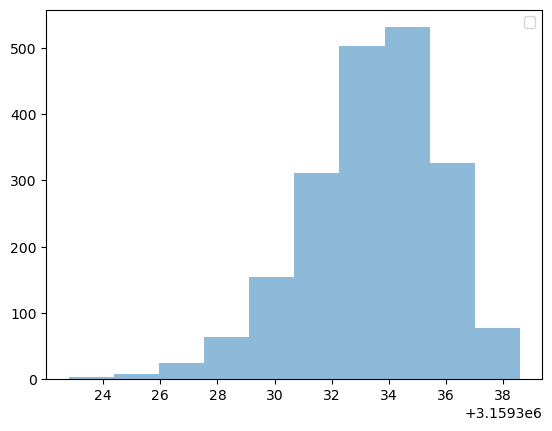

In [ ]:
plt.hist(log_lik[:,0,1], alpha = .5)
plt.legend()

In [ ]:
##change the likelihood function
def likelihood_splineless(params):
    src={k: v for k,v in zip(keys,params)}

    tdisignal = lisa.GenerateLISATDISignal_SMBH(src,
                                                gridfreq=fvec,
                                                **waveform_params_smbh)
    mbh_lb = tdisignal['tdi'][(2,2)]
    #SA = noise.psd(option='A',freq=mbh_lb['freq'])

    A_trial = np.conjugate((mbh_lb['amp_real_chan1'] + 1.j*mbh_lb['amp_imag_chan1'])*np.exp(1j* mbh_lb['phase']))
    E_trial = np.conjugate((mbh_lb['amp_real_chan2'] + 1.j*mbh_lb['amp_imag_chan2'])*np.exp(1j* mbh_lb['phase']))

    #SN_m = 4.0*df*np.sum( np.real((Afull*np.conjugate(A_trial) + Efull*np.conjugate(E_trial) ))/SA )
    SN_m = 4.0*df*np.sum(np.real(Afull*np.conjugate(A_trial))/Npsd) + 4.0*df*np.sum(np.real(Efull*np.conjugate(E_trial))/Npsd)

    #XX = 4.0*df*np.sum( (np.abs(A_trial)**2+np.abs(E_trial)**2) /SA )
    XX = 4*df*np.sum(np.abs(A_trial)**2/Npsd) + 4*df*np.sum(np.abs(E_trial)**2/Npsd)

    loglik = SN_m - 0.5*XX
    return loglik

In [ ]:
sampler_all_params_Splineless = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood_splineless,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)

In [ ]:
sampler_all_params_Splineless.run_mcmc(start_state, nsamples, progress=True)

100%|██████████| 2000/2000 [30:26<00:00,  1.10it/s]


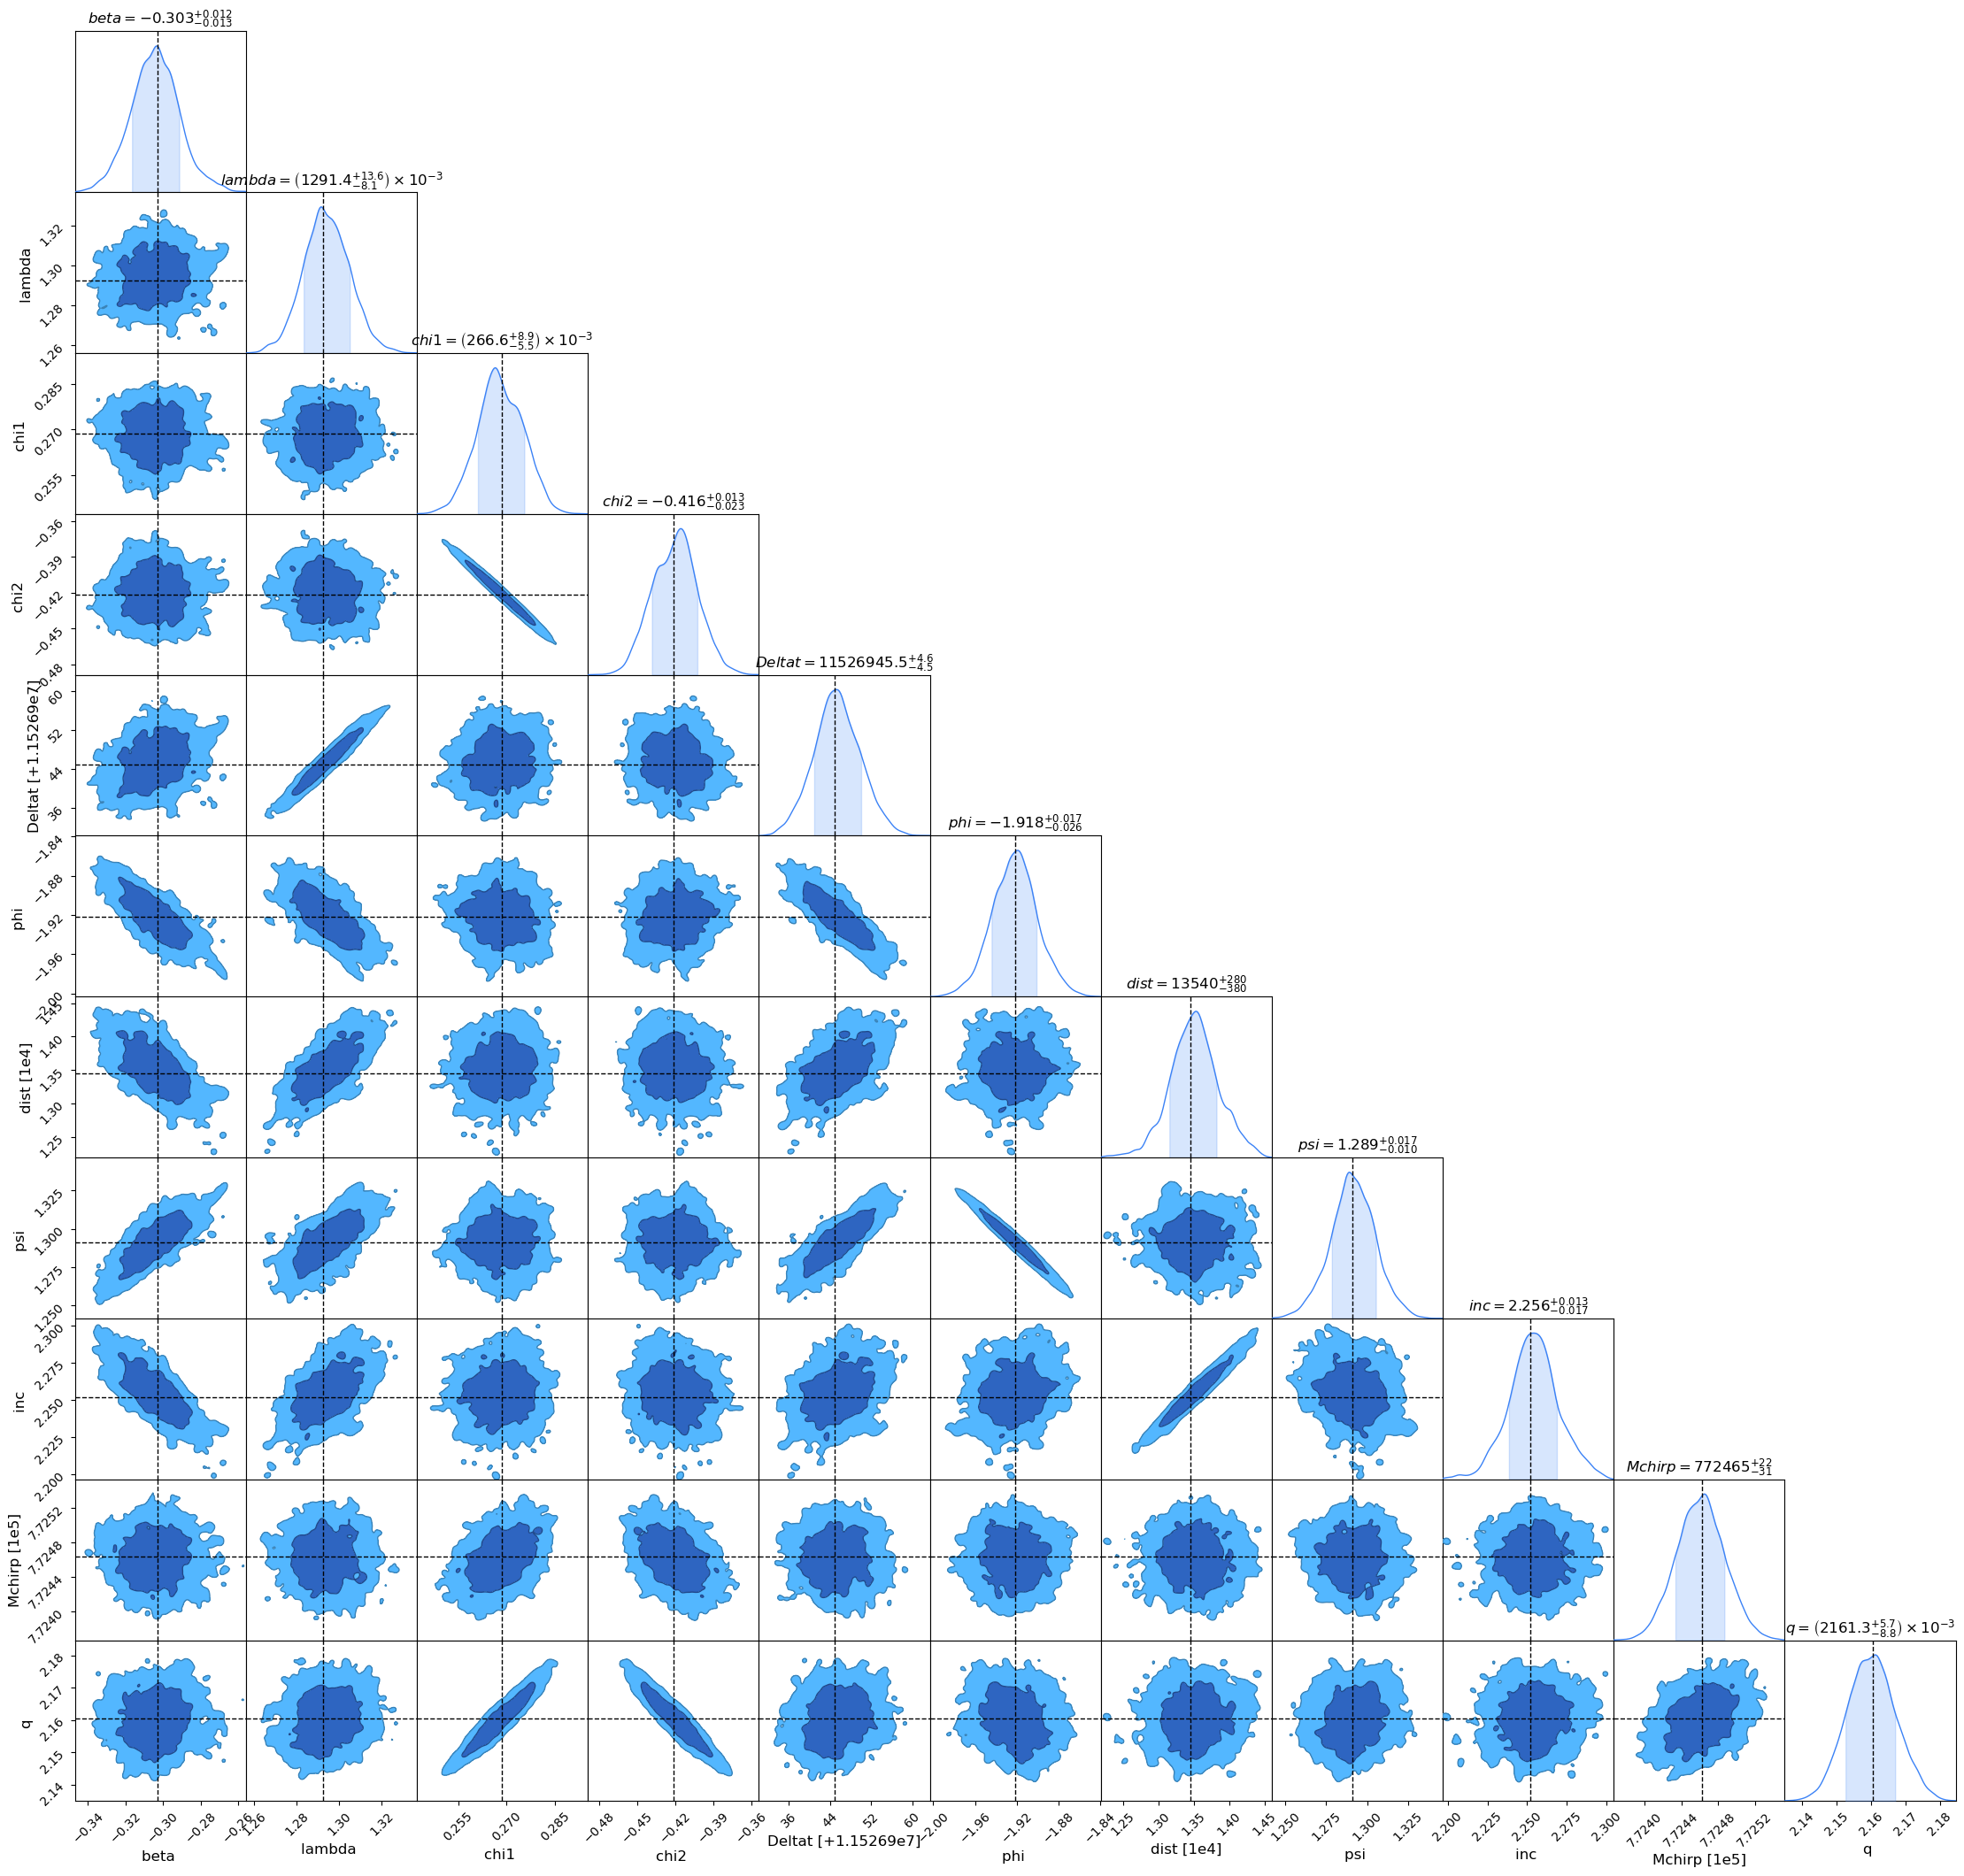

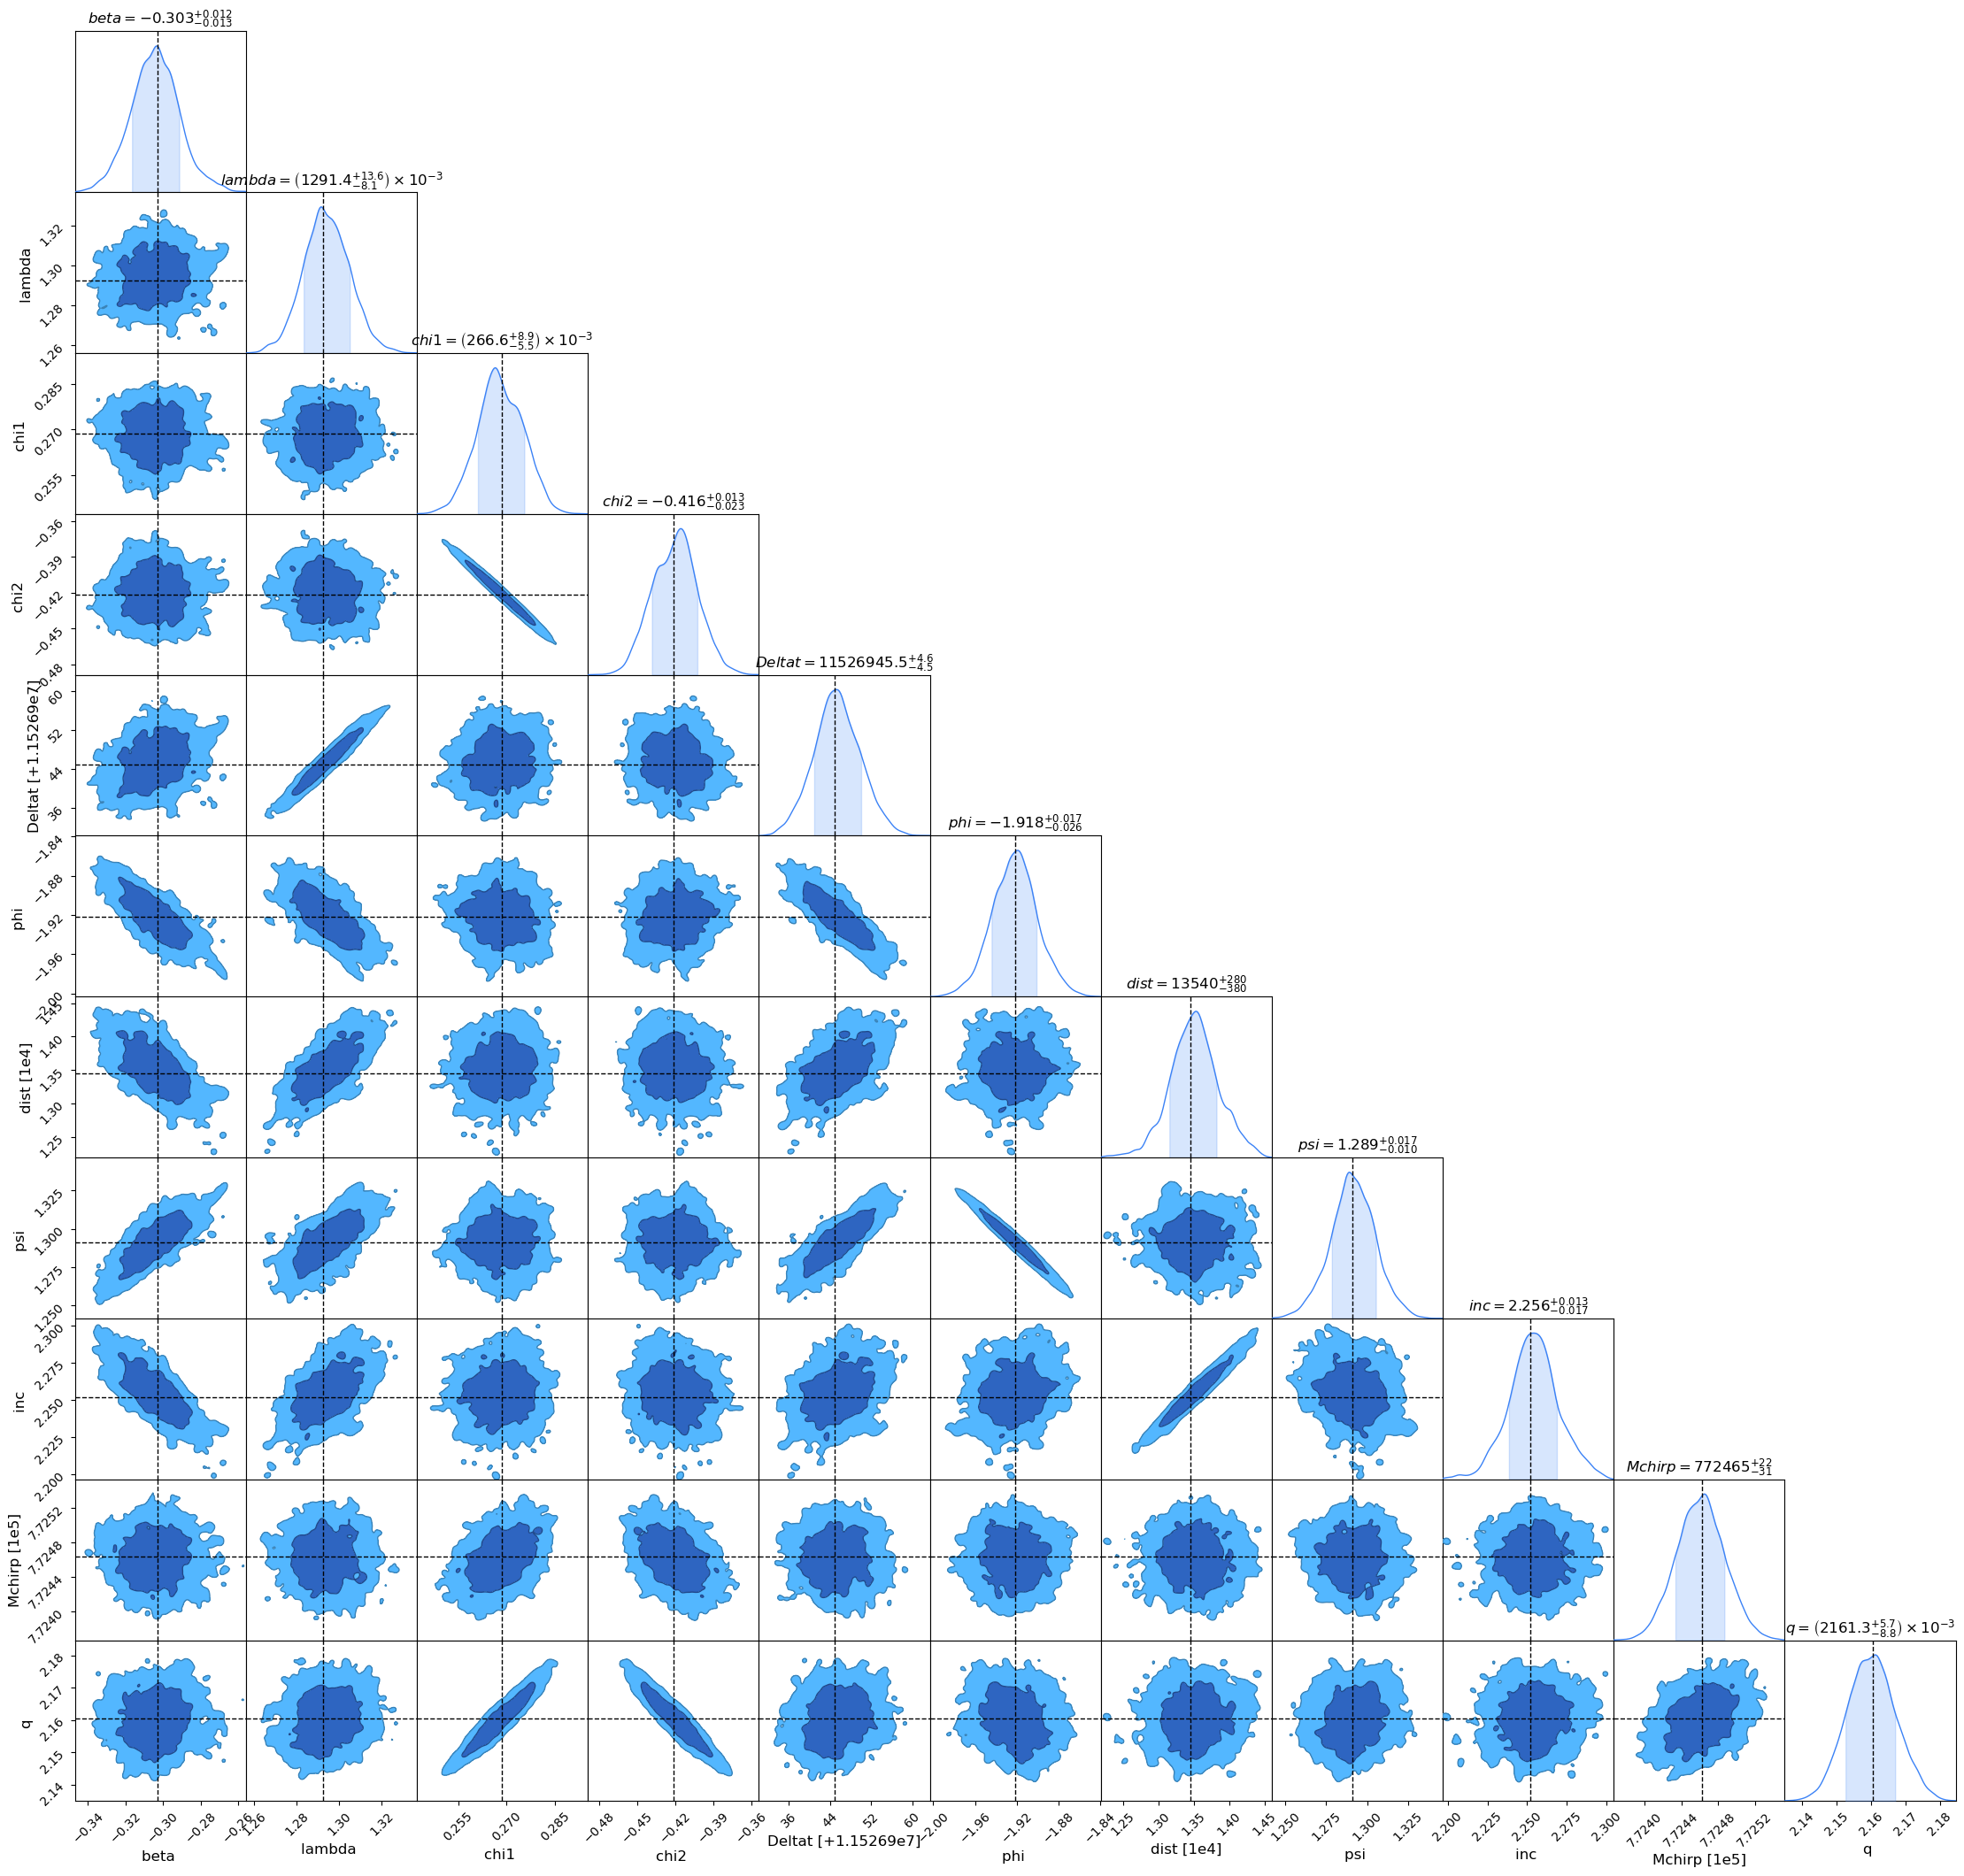

In [ ]:
burn = 15000

samples_splineless = sampler_all_params_Splineless.get_chain()["mbh"][:, 0].reshape(-1, 11)
dfs_splineless = pd.DataFrame(samples_splineless[burn:, :], columns=src0.keys())

b = ChainConsumer()

#
b.add_truth(Truth(location={k:v for (k,v) in zip(labels_final,truths)}))
#

b.add_chain(Chain(samples=dfs_splineless, name="splineless likelihood"))

b.plotter.plot()
#plt.show()

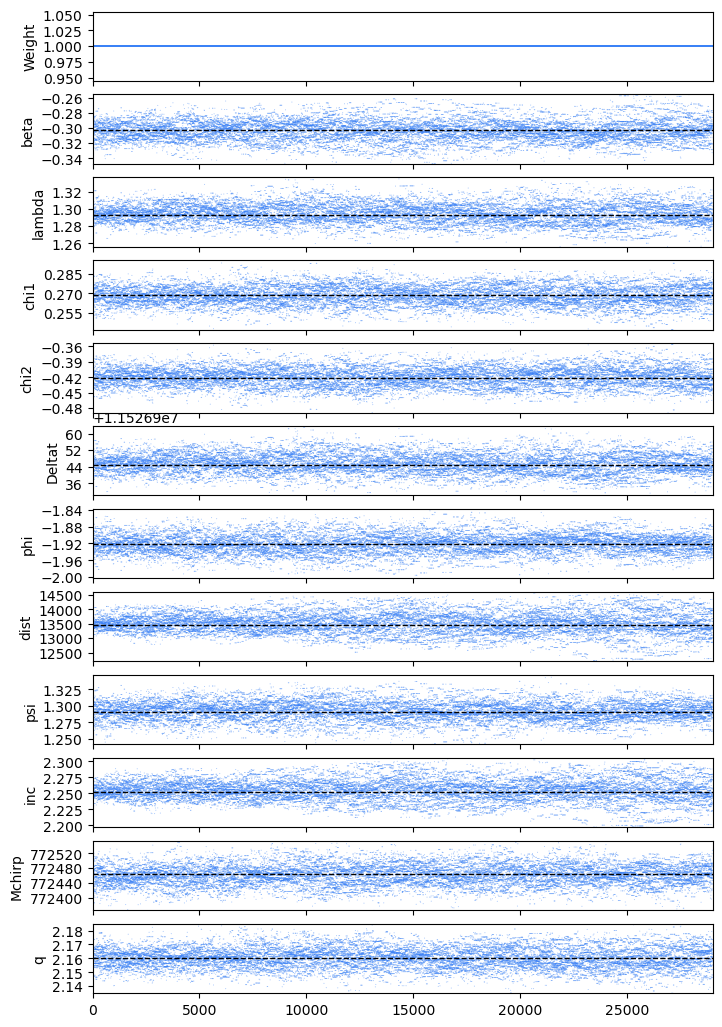

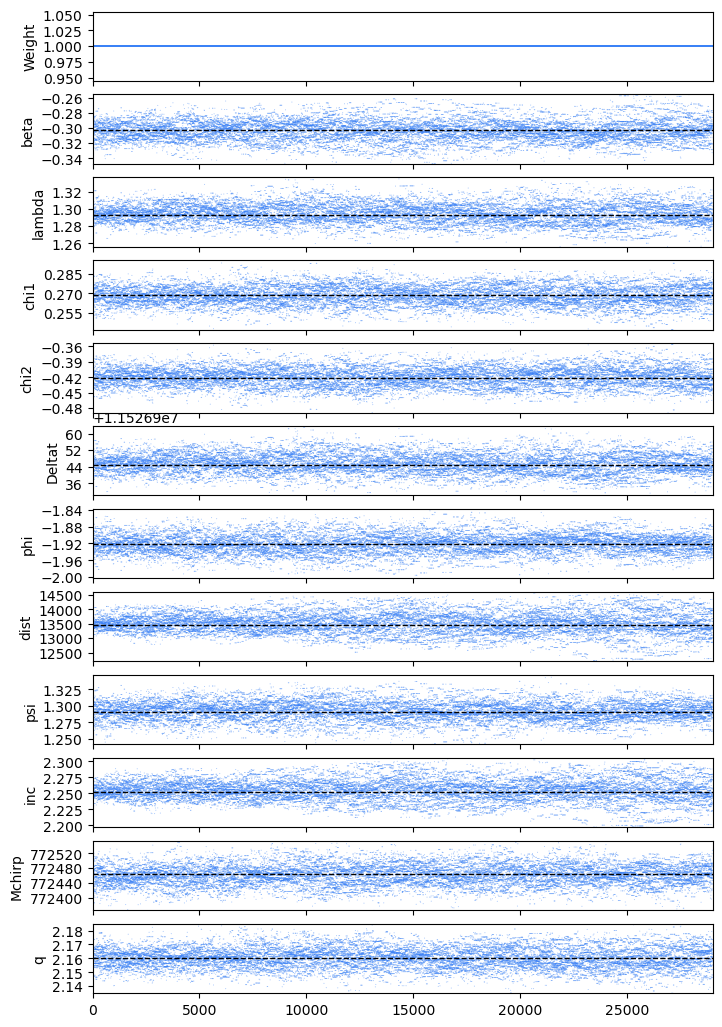

In [ ]:
b.plotter.plot_walks()

In [ ]:
#The likelihood that Robbie and I talked about (Hopefully properly normalized)
"""
def likelihood_normal(params):
    src={k: v for k,v in zip(keys,params)}

    tdisignal = lisa.GenerateLISATDISignal_SMBH(src,
                                                gridfreq=fvec,
                                                **waveform_params_smbh)
    mbh_lb = tdisignal['tdi'][(2,2)]
    #SA = noise.psd(option='A',freq=mbh_lb['freq'])

    A_trial = np.conjugate((mbh_lb['amp_real_chan1'] + 1.j*mbh_lb['amp_imag_chan1'])*np.exp(1j* mbh_lb['phase']))
    E_trial = np.conjugate((mbh_lb['amp_real_chan2'] + 1.j*mbh_lb['amp_imag_chan2'])*np.exp(1j* mbh_lb['phase']))


    Sn_m = np.sum(-0.5*(np.abs((Afull-A_trial))**2+np.abs((Efull-E_trial))**2)/Npsd)
    XX = 0.5*np.prod(np.log(2*np.pi*Npsd))

    loglik = Sn_m - XX
    
    return loglik

"""

In [ ]:
'''
sampler_all_params_normal = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood_normal,
    priors,
    args=(),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
)
'''

In [ ]:
'''
sampler_all_params_normal.run_mcmc(start_state, nsamples, progress=True)
'''

100%|██████████| 2000/2000 [44:21<00:00,  1.33s/it] 


In [ ]:
'''
burn = 15000

samples_normal = sampler_all_params_normal.get_chain()["mbh"][:, 0].reshape(-1, 11)
dfs_normal = pd.DataFrame(samples_normal[burn:, :], columns=src0.keys())

c = ChainConsumer()

c.add_truth(Truth(location={k:v for (k,v) in zip(labels_final,truths)}))
#

c.add_chain(Chain(samples=dfs_normal, name="normalized(hopefully) likelihood"))

c.plotter.plot()
'''

'\nburn = 15000\n\nsamples_normal = sampler_all_params_normal.get_chain()["mbh"][:, 0].reshape(-1, 11)\ndfs_normal = pd.DataFrame(samples_normal[burn:, :], columns=src0.keys())\n\nc = ChainConsumer()\n\nc.add_truth(Truth(location={k:v for (k,v) in zip(labels_final,truths)}))\n#\n\nc.add_chain(Chain(samples=dfs_normal, name="normalized(hopefully) likelihood"))\n\nc.plotter.plot()\n'

In [ ]:
'''
log_lik = sampler_all_params_normal.backend.get_log_like()
for i in range(0,20):
    plt.hist(log_lik[:,0,i], alpha = .5)
plt.show()
'''

'\nlog_lik = sampler_all_params_normal.backend.get_log_like()\nfor i in range(0,20):\n    plt.hist(log_lik[:,0,i], alpha = .5)\nplt.show()\n'

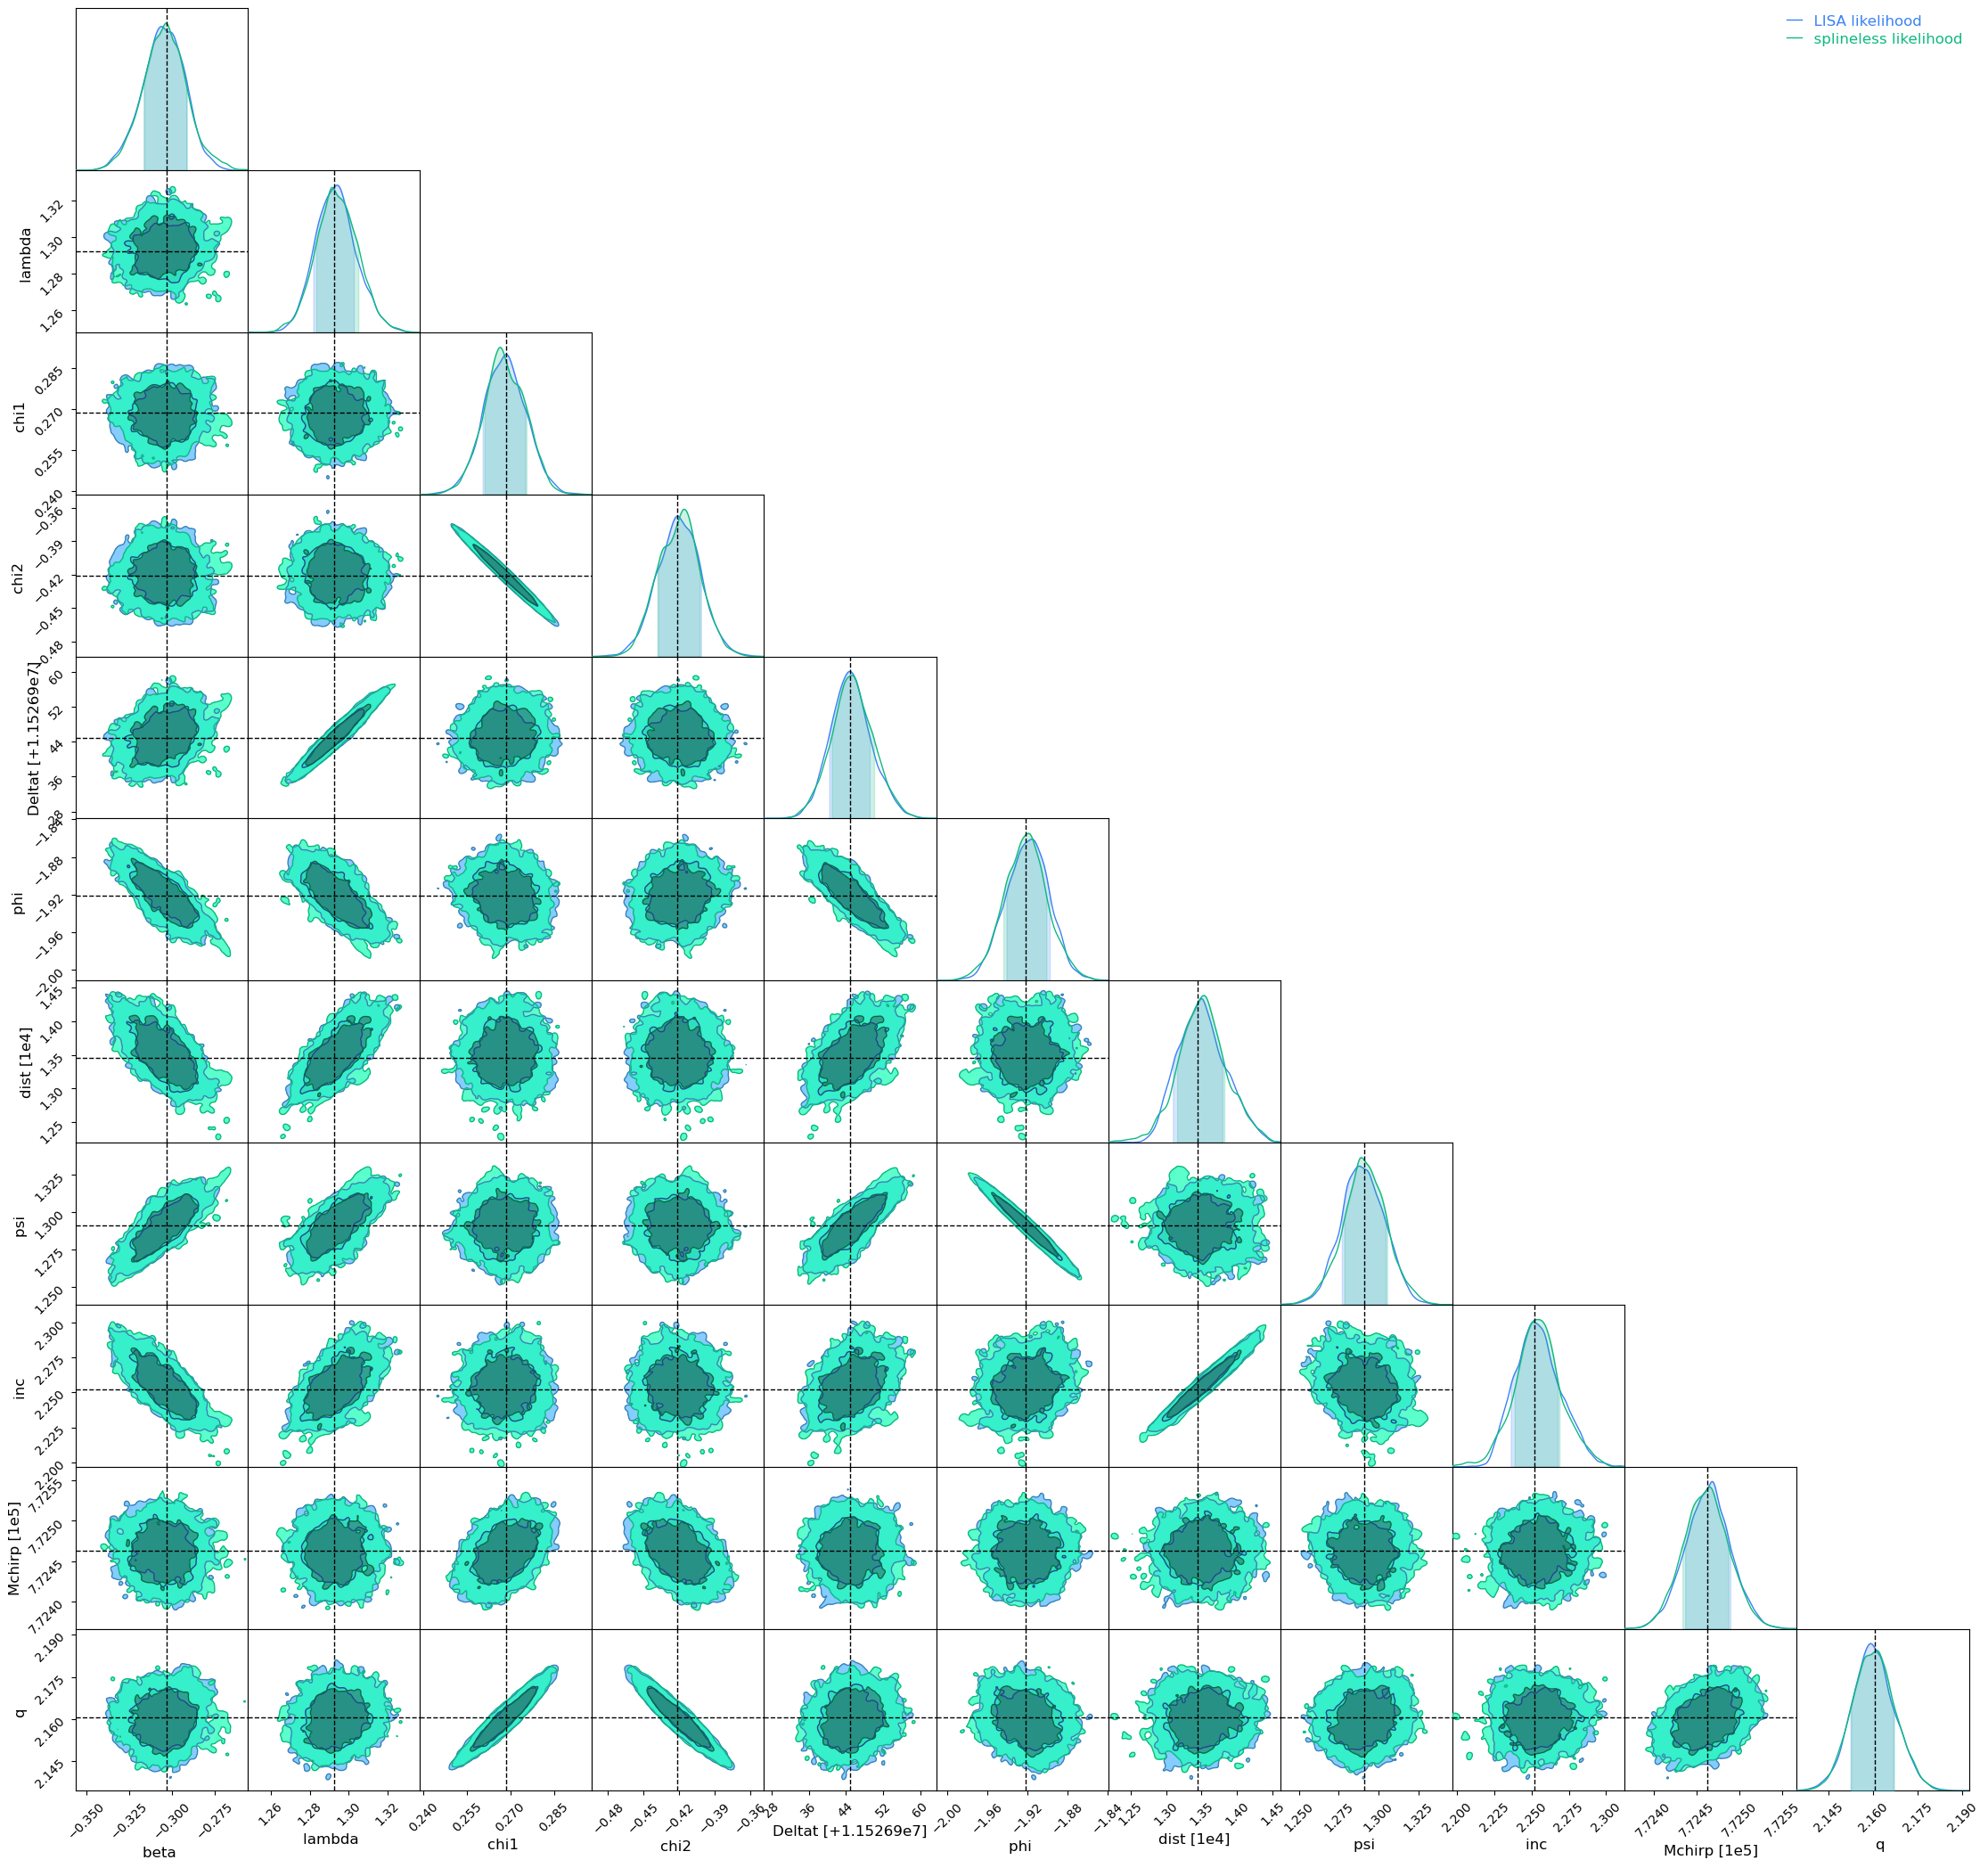

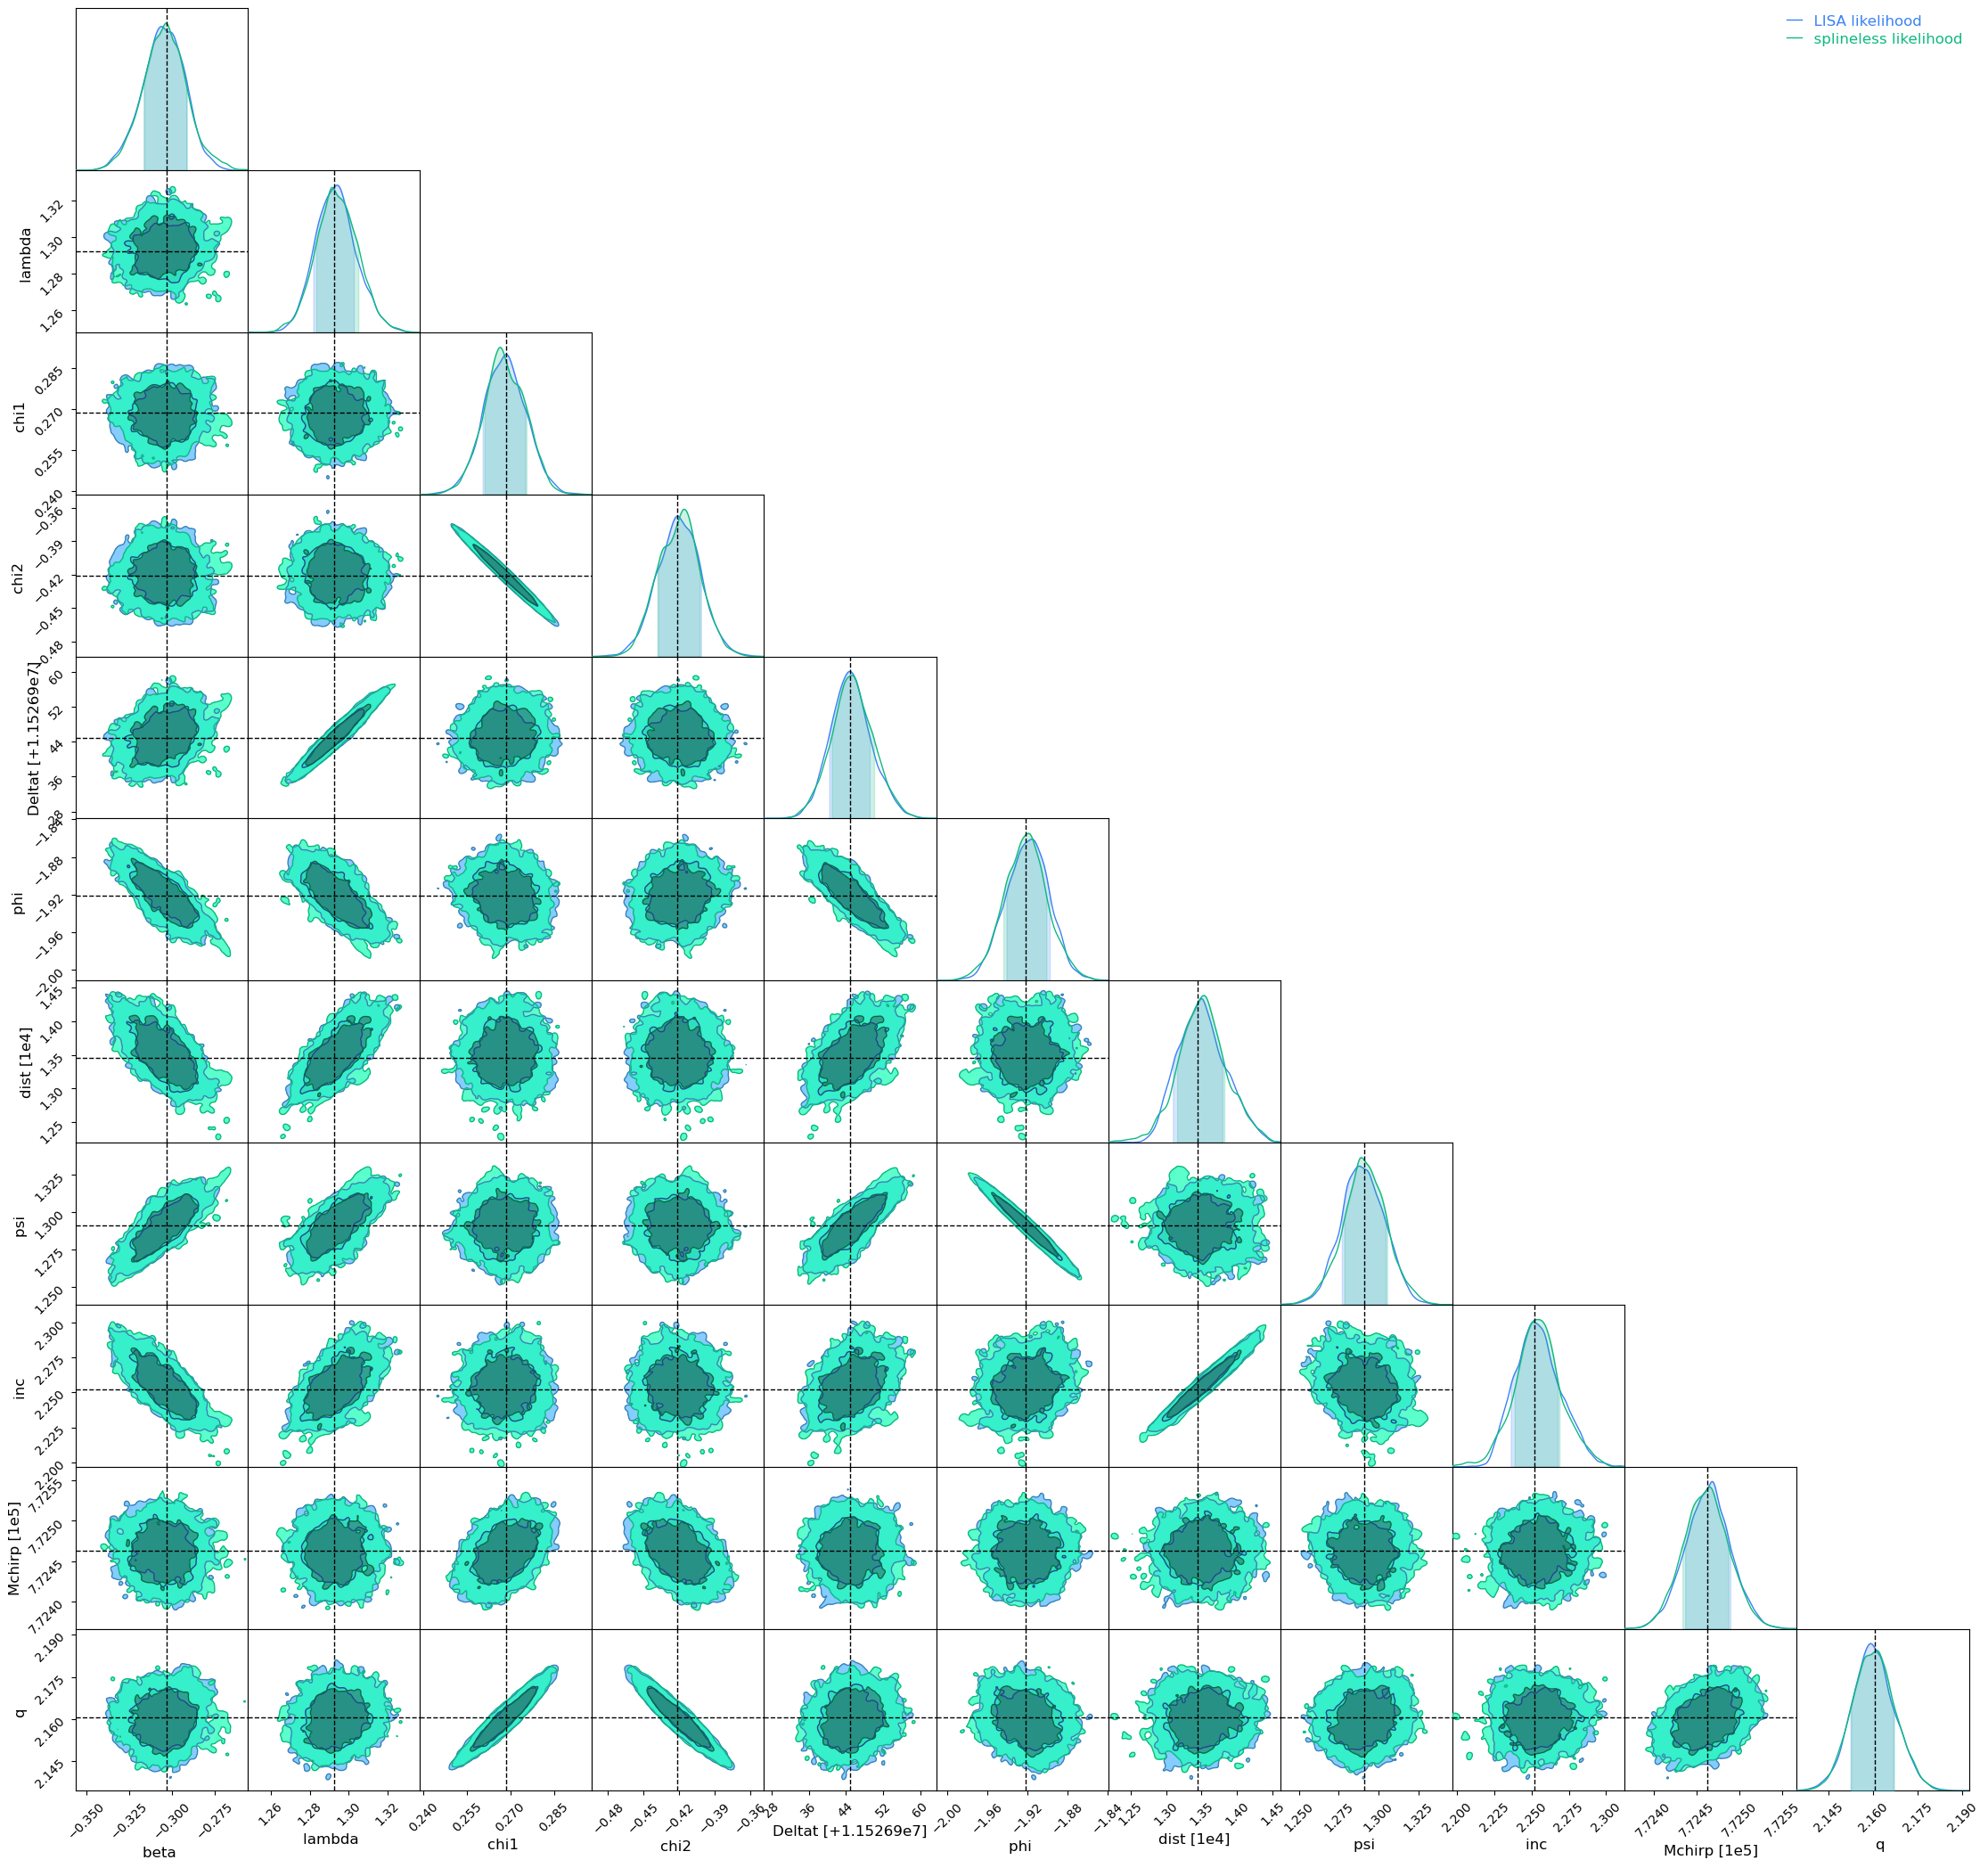

In [ ]:
#
c = ChainConsumer()
c.add_chain(Chain(samples=dfs_2chnls, name="LISA likelihood"))
#c.add_chain(Chain(samples=dfs_normal, name="base likelihood"))
c.add_chain(Chain(samples=dfs_splineless, name="splineless likelihood"))

c.add_truth(Truth(location={k:v for (k,v) in zip(labels_final,truths)}))

c.plotter.plot()


In [ ]:
#calculate the difference between two likelihood chain points
#log_lik_normal = sampler_all_params_normal.backend.get_log_like()
log_lik_interpolated = sampler_all_params.backend.get_log_like()
log_lik_robbie = sampler_all_params_Splineless.backend.get_log_like()

start_point = priors["mbh"].rvs()[0]
start_point2 = priors["mbh"].rvs()[0]
#print(start_point)


#trial3_1 = likelihood_normal(start_point)
#trial3_2 = likelihood_normal(start_point2)
trial2_1 = likelihood_splineless(start_point)
trial2_2 = likelihood_splineless(start_point2)
trial1_1 = likelihood_allchan(start_point)
trial1_2 = likelihood_allchan(start_point2)



print(trial1_2-trial1_1, 'lisa tutorial')
print(trial2_2-trial2_1, 'robbies emit')
#print(trial3_2-trial3_1, 'normal')
#print(trial3_2, trial3_1)


6296.333333880522 lisa tutorial
6296.333333883867 robbies emit
